In [1]:
## BEGIN
import numpy as np
import numpy.random as rnd
rnd.seed()
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import pickle as cp
import scipy.optimize as opt
from scipy.optimize import curve_fit as fit
#import mps
import cProfile
import itertools
from scipy.integrate import solve_ivp as ode
#%matplotlib notebook
#%matplotlib inlin  e
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import rc
#from matplotlib import cm
import matplotlib 
cmap = matplotlib.colormaps["Blues"]
plt.style.use("default")
rc('font', **{ "size":10}) # 
np.set_printoptions(precision=5)
rc('text', usetex=True)
rc("axes", linewidth= 1.1)


In [2]:
def init(theta = 0.3, T = 40):
    costh, sintheta = np.cos(theta / 4), np.sin(theta / 4)
    u = np.array([[costh,  1.j * sintheta], [ 1.j * sintheta, costh]])
    uut = np.kron(u, u.conj()) # Q - > u Q u^\dagger, vectorized 
    c2 = 2 * (np.cos(theta) ** 2)
    ts = np.arange(T + 1)
    etas = ((2 ** ts) * (1 + (np.cos(theta/2) ** 2) * (c2 ** (ts) - 1) / (c2 - 1))) ** .5
    return uut, etas

# decoherent history probe

## gather data

In [22]:
def getexact(t, uut, eta, delta):
    Nw = min(512, 2 ** (t-1))
    wmax = min(np.pi * 32 / eta, np.pi)
    ws = np.arange(Nw + 1) / Nw * wmax
    ms = np.arange(Nw * 2) * np.pi / ws[-1]
    ms[Nw:] -= Nw * 2 * np.pi / ws[-1]
    dm = (ms[1] - ms[0]) / eta
    ms = np.fft.fftshift(ms) / eta
    Q = np.array([np.exp(-1.j * ws), 0 * ws, 0 * ws, np.exp(1.j * ws)]) #* ((uut @ Q) ** 2).reshape(4, 1),
    for s in range(t):
        Q = uut @ (uut @ Q) ** 2
    Pw0 = (Q[0] + Q[-1]) / 2 * np.exp(- (eta * delta) ** 2 * ws ** 2 / 2)
    Pm0 = np.fft.fftshift(np.fft.irfft( (Pw0 / Pw0[0])) )
    Pm0 = np.clip(Pm0, 0, 1) 
    Pm0 /= np.sum(Pm0) * dm
    #print(len(ms), len(Pm0))
    return ms, Pm0
def getdephased(t, t0, uut, etas, sigmats, maxrep = 2000):
    Nw = min(512, 2 ** (t-1))
    wmax = min(np.pi * 32 / etas[t], np.pi)
    ws = np.arange(Nw + 1) / Nw * wmax
    ms = np.arange(Nw * 2) * np.pi / ws[-1]
    ms[Nw:] -= Nw * 2 * np.pi / ws[-1]
    dm = (ms[1] - ms[0]) / etas[t]
    ms = np.fft.fftshift(ms) / etas[t]
    Pw = np.zeros(len(ws), dtype=complex)    
    for rep in range(maxrep):
        upvs = 1.j * rnd.randn(t + 1 - t0) / sigmats[t0: t + 1] 
        Q = np.array([np.exp(-1.j * ws), 0 * ws, 0 * ws, np.exp(1.j * ws)])
        for s in range(t - 1, t0 - 1, -1):
            upv = upvs[s - t0]
            Q =  np.exp([0, upv, -upv, 0]).reshape(4,1) * (uut @ (uut @ Q) ** 2)
        for s in range(t0):
            Q = uut @ (uut @ Q) ** 2
        dPw = (Q[0] + Q[-1]) / 2 * np.exp(-sigmats[t] ** 2 * ws ** 2 / 2)
        Pw = Pw + dPw
        #Pwerr = Pwerr + np.abs(dPw) ** 2
    Pm = np.fft.irfft( (Pw / Pw[0])) 
    Pm = np.clip(Pm, 0, 1) 
    Pm /= np.sum(Pm)
    Pm = np.fft.fftshift(Pm) / dm
    return ms, Pm

In [4]:
res_ex = dict()
res_dephase = dict()
res_dephase_1 = dict()

In [5]:
delta = .1
T = 25
theta = .3 * np.pi / 2
uut, etas = init(theta, T)
for L in [6, 10]:
    for t0 in np.arange(1, 11):
        t = t0 + L
        ms, Pm0 = getexact(t, uut, etas[t], delta)
        res_ex[t, theta, delta] = (ms, Pm0)
        sigmats = etas * delta
        print(".", end = "")
        ms, Pm = getdephased(t, t0, uut, etas, sigmats)
        res_dephase[t, t0, theta, delta] = (ms, Pm)
        sigmats[:t] = delta
        ms, Pm = getdephased(t, t0, uut, etas, sigmats)
        res_dephase_1[t, t0, theta, delta] = (ms, Pm)
        print("x", end = "")
        
        #diffs[k] = (np.sum( np.abs(Pm - Pm0) * (ms[1] - ms[0])))

.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x

In [24]:
delta = .1
T = 40
theta = .6 * np.pi / 2
uut, etas = init(theta, T)
for L in np.arange(6, 15):
    t0list = range(1, 11)
    for t0 in t0list:
        t = t0 + L
        ms, Pm0 = getexact(t, uut, etas[t], delta)
        res_ex[t, theta, delta] = (ms, Pm0)
        sigmats = etas * delta
        print(".", end = "")
        ms, Pm = getdephased(t, t0, uut, etas, sigmats)
        res_dephase[t, t0, theta, delta] = (ms, Pm)
        sigmats[:t] = delta
        ms, Pm = getdephased(t, t0, uut, etas, sigmats)
        res_dephase_1[t, t0, theta, delta] = (ms, Pm)
        print("x", end = "")
        
        #diffs[k] = (np.sum( np.abs(Pm - Pm0) * (ms[1] - ms[0])))

.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x.x

In [25]:
delta = .1
T = 40
theta = .75 * np.pi / 2
uut, etas = init(theta, T)
t0 = 6
for L in np.arange(6, 15):
    t = t0 + L
    ms, Pm0 = getexact(t, uut, etas[t], delta)
    res_ex[t, theta, delta] = (ms, Pm0)
    sigmats = etas * delta
    print(".", end = "")
    ms, Pm = getdephased(t,t0, uut, etas, sigmats)
    res_dephase[t, t0, theta, delta] = (ms, Pm)
    sigmats[:t] = delta
    ms, Pm = getdephased(t,t0, uut, etas, sigmats)
    res_dephase_1[t, t0, theta, delta] = (ms, Pm)
    print("x", end = "")
        
        #diffs[k] = (np.sum( np.abs(Pm - Pm0) * (ms[1] - ms[0])))

.x.x.x.x.x.x.x.x.x

## make figure

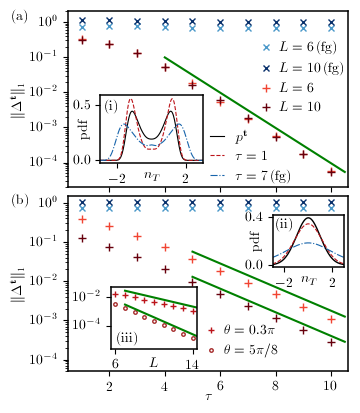

In [43]:
delta = .1
fig, axes = plt.subplots(2,1, figsize = (3.41, 4.), sharex = "all")
axes = axes.reshape(-1)
theta = .3 * np.pi  / 2
cmap = matplotlib.colormaps["Reds"]
cmap1 = matplotlib.colormaps["Blues"]
for L in [6, 10]:
    color = cmap(L / 10)
    color1 = cmap1(L / 10)
    t0s = np.arange(1, 11)
    diffs = np.zeros(len(t0s))
    diffs1 = np.zeros(len(t0s))
    for k,t0 in enumerate(t0s):
        t = t0 + L
        ms, Pm0 = res_ex[t, theta, delta]
        ms, Pm =  res_dephase[t, t0, theta, delta]
        diffs[k] = (np.sum( np.abs(Pm - Pm0) * (ms[1] - ms[0])))
        ms, Pm =  res_dephase_1[t, t0, theta, delta]
        diffs1[k] = (np.sum( np.abs(Pm - Pm0) * (ms[1] - ms[0]))) 
    plt.sca(axes[0])
    
    plt.plot(t0s, diffs, "+", label = r"$L=%d$" % L, c = color, markersize = 6)
    plt.plot(t0s, diffs1, "x", label = r"$L=%d \,\mathrm{(fg)}$" % L, c = color1, markersize = 4)
plt.yscale("log")
ts = np.linspace(4, 10.5, 20)
plt.plot(ts, (2 * np.cos(theta)) ** ( - ts * 2) / delta ** 2 / 10, "g-")
plt.xlim(0.5, 10.5)
plt.ylim(2e-5, 2)
plt.ylabel(r"$\Vert \Delta^{\mathbf{t}} \Vert_1 $") 
axes[1].set_xlabel(r"$\tau$", labelpad = -5)
plt.text(-.2, .95, r"$\mathrm{(a)}$", transform = axes[0].transAxes)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,3, 0,2,]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           frameon = False, bbox_to_anchor = (.66, .9), handlelength = 0.2, loc = 2)
inset = plt.axes([.265, .6, .3, .17])
plt.sca(inset)
plt.plot(*res_ex[11, theta, delta], "k" , lw = .8, label = r"$p^{\mathbf{t}}$")
plt.plot(*res_dephase[11, 1, theta, delta], "--", lw = .8, c = cmap(.8), label = r"$\tau=1$")
#plt.plot(*res_dephase[11, 6, theta, delta], "--")
plt.plot(*res_dephase_1[11, 5, theta, delta], "-.", lw = .8,  c = cmap1(.8), label = r"$\tau=7\,\mathrm{(fg)}$ ")
plt.legend(frameon = False, bbox_to_anchor = (.95, .68), handlelength = 1, loc = 2)
plt.xlim(-3,3)
plt.xticks([-2, 2])
plt.yticks([0, .5])
plt.xlabel(r"$n_T$", labelpad = -12)
plt.ylabel(r"$\mathrm{pdf}$", labelpad = -12)

plt.text(.05, .78, r"$\mathrm{(i)}$" , transform = inset.transAxes)
###################
theta = .6 * np.pi  / 2
for L in [6, 10]:
    color = cmap(L / 10)
    color1 = cmap1(L / 10)
    t0s = np.arange(1, 11)
    diffs = np.zeros(len(t0s))
    diffs1 = np.zeros(len(t0s))
    for k,t0 in enumerate(t0s):
        t = t0 + L
        ms, Pm0 = res_ex[t, theta, delta]
        ms, Pm =  res_dephase[t, t0, theta, delta]
        diffs[k] = (np.sum( np.abs(Pm - Pm0) * (ms[1] - ms[0])))
        ms, Pm =  res_dephase_1[t, t0, theta, delta]
        diffs1[k] = (np.sum( np.abs(Pm - Pm0) * (ms[1] - ms[0]))) 
    plt.sca(axes[1])
    
    plt.plot(t0s, diffs , "+", label = r"$L=%d$" % L, c = color, markersize = 6)
    plt.plot(t0s, diffs1, "x", label = r"$L=%d \, \mathrm{(fg)}$ " % L, c = color1, markersize = 4)
    ts = np.linspace(5, 10.5, 20)
    plt.plot(ts, (2) ** (-ts - L) * (2 * np.cos(theta)) ** (2 * L) / delta ** 2 / 6,  "g-")
plt.yscale("log")
plt.xlim(.5, 10.6)
plt.ylim(5e-5, 1.5)
plt.ylabel(r"$\Vert \Delta^{\mathbf{t}} \Vert_1 $") 
axes[1].set_xlabel(r"$\tau$", labelpad = -2)
#handles, labels = plt.gca().get_legend_handles_labels()
#order = [0,2,1,3]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
#           frameon = False, bbox_to_anchor = (.63, .82), handlelength = 0.2, loc = 2)
inset = plt.axes([.77, .34, .21, .13])
plt.sca(inset)
plt.plot(*res_ex[11, theta, delta], "k", lw = 1,)
plt.plot(*res_dephase[11, 1, theta, delta], "--", lw = .8, c = cmap(.8))
#plt.plot(*res_dephase[11, 6, theta, delta], "--")
plt.plot(*res_dephase_1[11, 5, theta, delta], "-.", lw = .8,  c = cmap1(.8))
plt.xlim(-3,3)
plt.xticks([-2, 2])
plt.yticks([0, .4])
plt.xlabel(r"$n_T$", labelpad = -12)
plt.ylabel(r"$\mathrm{pdf}$", labelpad = -12)
plt.text(.05, .75, r"$\mathrm{(ii)}$" , transform = inset.transAxes)
inset1 = plt.axes([.295, .135, .255, .155])
plt.sca(inset1)
t0 = 6
Ls = np.arange(6, 15)
for i,theta in enumerate([.6 * np.pi/2, .75 * np.pi / 2]):
    diffs = np.zeros(len(Ls))
    for k,L in enumerate(Ls):
        t = t0 + L
        ms, Pm0 = res_ex[t, theta, delta]
        ms, Pm =  res_dephase[t, t0, theta, delta]
        diffs[k] = (np.sum( np.abs(Pm - Pm0) * (ms[1] - ms[0])))
        #ms, Pm =  res_dephase_1[t, t0, theta, delta]
        #diffs1[k] = (np.sum( np.abs(Pm - Pm0) * (ms[1] - ms[0]))) 
    plt.plot(Ls, diffs, "+" if i == 0 else ".", c = cmap(.8) if i == 0 else "brown" , 
             fillstyle="none",  markersize = 5, 
             label = r"$\theta = 0.3\pi$" if i == 0 else r"$\theta = 5\pi/8$")
    xx = np.linspace(7., 15)
    plt.plot(xx, 2. ** (-xx) * ( max(2 * np.cos(theta), 1)) ** (2 * xx) * 2 ** (-t0) / delta ** 2 / 4 , "g")
plt.legend(bbox_to_anchor = (1., .6), frameon = 0, loc=2, handlelength = .2)
plt.text(.08, .12, r"$\mathrm{(iii)}$" , transform = inset1.transAxes)
plt.yscale("log")
plt.xticks([6,14])
plt.text(-.2, .95, r"$\mathrm{(b)}$", transform = axes[1].transAxes)
plt.xlabel(r"$L$", labelpad = -10)
plt.ylim(2e-6, 5e-2)
plt.xlim(5.5, 14.5)
plt.subplots_adjust(left = 0.17, bottom = .08, top = 0.98, right = 0.99, hspace = 0.05)
plt.savefig("../Desktop/darwism/Quantum_or_classical_/Delta.pdf")

# pointers

In [715]:
th, Zsp = np.meshgrid(np.linspace(0, np.pi * 2, 50), np.linspace(1, -1, 50))
Xsp, Ysp = (1-Zsp**2) ** .5 * np.cos(th), (1-Zsp**2) ** .5 * np.sin(th)

In [716]:
def getdata(theta):
    uut, etas = init(theta, 25)
    t = 20
    delta = .1
    eta = etas[t]
    Nw = min(512, 2 ** (t-1))
    wmax = min(np.pi * 64 / eta, np.pi)
    ws = np.arange(Nw * 2) / Nw * wmax
    ws[Nw:] -= wmax * 2
    ms = np.arange(Nw * 2) * np.pi / wmax
    ms[Nw:] -= Nw * 2 * np.pi / wmax
    dm = (ms[1] - ms[0]) / eta
    ms = np.fft.fftshift(ms) / eta
    Q = np.array([np.exp(-1.j * ws), 0 * ws, 0 * ws, np.exp(1.j * ws)]) #* ((uut @ Q) ** 2).reshape(4, 1),
    for s in range(t):
        Q = uut @ ((uut @ Q) ** 2)
    Q *= np.exp(- (eta * delta) ** 2 * ws ** 2 / 2)
    paulis = np.array([[1, 0,0,1], [0, 1, 1, 0], [0, 1.j, -1.j, 0], [1,0,0,-1] ])
    Qm = paulis @ np.array([np.fft.fftshift(np.fft.ifft((x))) for x in Q]) / 2
    pm = np.clip(Qm[0].real, 0,1)
    pm /= np.sum(pm)
    x, y, z = Qm[1:, ].real / pm
    y = -y
    return ms, pm, x, y, z
    #pm /= dm

/var/folders/3f/3zmgj55j1fvf3rscx4ly9p6c0000gp/T/ipykernel_1291/3033569153.py:22: RuntimeWarning: divide by zero encountered in divide
  x, y, z = Qm[1:, ].real / pm
/var/folders/3f/3zmgj55j1fvf3rscx4ly9p6c0000gp/T/ipykernel_1291/3033569153.py:22: RuntimeWarning: divide by zero encountered in divide
  x, y, z = Qm[1:, ].real / pm


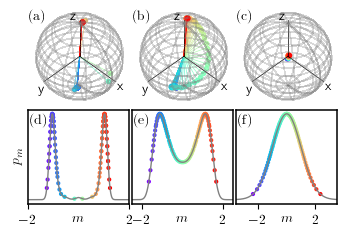

In [729]:
#fig, axes =  plt.subplots(1, 3 ,subplot_kw={"projection": "3d"}, figsize = (3.4, 1.2), frameon=False)
#axes = axes.reshape(-1)
cmap = matplotlib.colormaps["rainbow"]
fig = plt.figure(figsize = (3.4, 2.2))
thetas = np.array([.1, .3, .6]) * np.pi / 2
for i, theta in enumerate(thetas):
    ms, pm, x, y, z = getdata(theta)
#ax.scatter(x[filter], y[filter], z[filter], s = pm[filter] * 20, c = pm[filter], cmap = "Reds")
    pcum = np.cumsum(pm) 
    
    sample = np.searchsorted(pcum, np.linspace(0, 1, 102)[1:-1])
    msamples = ms[sample]
    mmin = np.min(msamples)
    mmax = np.max(msamples)
    ax = fig.add_subplot(2, 3, i + 1,  projection='3d')

    surf = ax.plot_wireframe(Xsp, Ysp, Zsp, alpha = .3, rstride = 4, cstride = 4,
                           linewidth=0.5, antialiased= False, color = "grey")
    ax.grid(False)
    #ax.set_frame(False)

  #  print(mmin, mmax)
    for j, s in enumerate(sample):
        p = (ms[s] - mmin) / (mmax - mmin)
        c = cmap(p)
        r = (x[s] ** 2 + y[s] ** 2 + z[s] ** 2) ** .5
        ax.plot([0, x[s]], [0, -y[s]], [0, z[s]], lw = .5, c = c, alpha = .8)
        ax.plot([ x[s]], [ -y[s]], [z[s]], "o", ms = 3, c = c, alpha = .8)
    ax.plot([0, 1.1], [0, 0], [0,0], c = "k", lw = .5)
    ax.plot([0, 0], [0, -1.1], [0,0], c = "k", lw = .5)
    ax.plot([0, 0], [0, 0], [0,1.1], c = "k", lw = .5)
    #ax.scatter(x[sample], y[sample], z[sample], c = r[sample], cmap = "Greys")
    ax.set_xlim(-.5,.5)
    ax.set_ylim(-.8,.8)
    ax.set_zlim(-.5,.5)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])
    ax.view_init(45, -45, 0)
    ax.set_aspect("equal")
    ax = fig.add_subplot(2, 3, i + 3 + 1)
    ax.plot(ms, pm / (ms[1] - ms[0]), lw = 1., c = "grey")
    ax.scatter(ms[sample], pm[sample] / (ms[1] - ms[0]), c = (ms[sample] - mmin) / (mmax - mmin), cmap = "rainbow"
              , s = 4.)
    plt.xlim(mmin * 1.5, mmax * 1.5)
    plt.yticks([])
    plt.xticks([-2, 2])
    plt.xlabel(r"$m$", labelpad = -10)
    if i == 0:
        plt.ylabel(r"$p_m$")
    plt.text(.88, 1.21, r"$\mathsf{x}$", transform = ax.transAxes)
    plt.text(.1, 1.18, r"$\mathsf{y}$", transform = ax.transAxes)
    plt.text(.42, 1.95, r"$\mathsf{z}$", transform = ax.transAxes)
    plt.text(0.01, 1.95, r"$\mathrm{(%s)}$" % (chr(ord('a') + i)),  transform = ax.transAxes)
    plt.text(.02, .85, r"$\mathrm{(%s)}$" % (chr(ord('d') + i)),  transform = ax.transAxes)       
plt.subplots_adjust(left = 0.07, right = 0.98, top = 0.98, bottom = 0.1, wspace = 0.03, hspace = 0.05)
plt.savefig("../Desktop/darwism/Quantum_or_classical_/pointers.pdf")

/var/folders/3f/3zmgj55j1fvf3rscx4ly9p6c0000gp/T/ipykernel_1291/3033569153.py:22: RuntimeWarning: divide by zero encountered in divide
  x, y, z = Qm[1:, ].real / pm


(-4.0, 4.0)

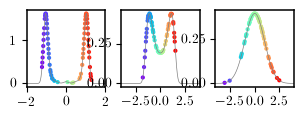

In [719]:
fig, axes = plt.subplots(1, 3, figsize = (3.45, 1.), frameon=False)
for theta, ax in zip(thetas, axes):
    plt.sca(ax)
    ms, pm, x, y, z = getdata(theta)
    msamples = ms[sample]
    mmin = np.min(msamples)
    mmax = np.max(msamples)
    sample = (rnd.choice(len(pm), p = pm, replace = False, size = 64))
    ax.plot(ms, pm / (ms[1] - ms[0]), lw = .5, c = "grey")
    ax.scatter(ms[sample], pm[sample] / (ms[1] - ms[0]), c = (ms[sample] - mmin) / (mmax - mmin), cmap = "rainbow"
              , s = 4.)
axes[0].set_xlim(-2,2)
axes[1].set_xlim(-4,4)
axes[2].set_xlim(-4,4)

# Leggett Garg

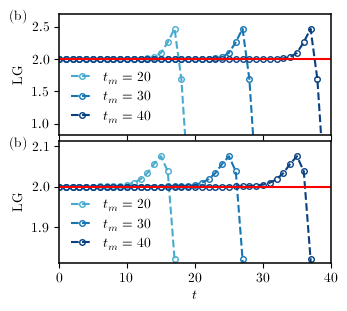

In [4]:

#

Z = np.array([1, 0, 0, -1])
X = np.array([0, 1, 1, 0])
Y = np.array([0, -1.j, 1.j, 0])
maxs = []



def C12(t1, t2, left = True):
    """calculate correlation function,
       <O(t2) O(t1) > if left is true 
       <O(t1) O(t2)> otherwise
     """
    assert t1 <= t2 
    Q = Op
    for s in range(t2 - t1):
        Q = (uut @ Q) ** 2
    Q = Q.reshape(2, 2)
    
    Q = (Q @ Op.reshape(2,2)) if left else (Op.reshape(2,2) @ Q) 
    #else:
    Q = Q.reshape(4)
    for s in range(t1):
        Q = (uut @ Q) ** 2
    #print()
    return (Q[0] + Q[-1])/ 2
    #return np.sum(Q) / 2
def C12K(t1, t2):
    """calculate Keldysh correlation (anti-commutator)"""
    return (C12(t1, t2) + C12(t1, t2, False) ) / 2
fig, ax = plt.subplots(2,1, figsize = (3.4, 3.), sharex="all")
ax = ax.reshape(-1)
cmap = matplotlib.colormaps["GnBu"]
for k,J in enumerate([.3, .7]):
    c2 = 2 * np.cos(J * np.pi / 2) ** 2
    plt.sca(ax[k])
    costh, sintheta = np.cos(J * np.pi / 4), np.sin(J * np.pi / 4)
    u = np.array([[costh,1.j * sintheta], [1.j * sintheta, costh]])
    #u = np.array([[costh,  sintheta], [- sintheta, costh]])
    uut = np.kron(u, u.conj()) # Q - > u Q u^\dagger, vectorized 
    y = np.pi * J / 4 
    factor = max(2 ** .5, np.cos(J * np.pi / 2) * 2)
    
    for tmax in np.array([20,30,40]):
        x = 1 / factor ** tmax
        a, b, c = np.sin(x) * np.sin(y), np.cos(x), np.sin(x) * np.cos(y)
        Op = Z * a + X * b + Y * c
        LGs = []
        for t0 in range(1, 45):
            ts = np.arange(4) + t0
            #Cs = [ C12K(ts[0], ts[1]) ,C12K(ts[1], ts[2]), C12K(ts[2], ts[3]), C12K(ts[0], ts[3])] 
            Cs = [ C12K(ts[0], ts[1]) ,C12K(ts[1], ts[2]), C12K(ts[2], ts[3]), C12K(ts[0], ts[3])] 
            #print(Cs)
            LGs.append( (sum(Cs[:-1]) - Cs[-1]).real - 2)
            #maxs.append(np.max(LGs))
        
        plt.plot(np.arange(len(LGs)), np.array(LGs) + 2, "o--", c = cmap(tmax / 40 * .7 + .3), 
                 label = r"$t_m = %d$" % tmax, markersize = 4, fillstyle = "none")
        plt.ylim(2 - np.max(LGs) * 2.5, np.max(LGs) * 1.5 + 2)
    plt.ylabel(r"$\mathrm{LG}$", labelpad=4)
    plt.plot([0, 40], [2,2], "red")
    plt.xlim(0, 40)
    plt.legend(frameon = False, handlelength = 1.5)
#ax[1].set_ylim(1.5, np.max(LGs) * 1.5 + 2)
plt.xlabel("$t$",labelpad = 3)
ax[0].text(-.18, .95, r"$\mathrm{(b)}$", transform = ax[0].transAxes)
ax[1].text(-.18, .95, r"$\mathrm{(b)}$", transform = ax[1].transAxes)
plt.subplots_adjust(left = 0.17, bottom = .15, top = 0.98, right = 0.97, hspace = 0.05)
plt.savefig("../Desktop/darwism/Quantum_or_classical_/LG.pdf")

# tree figure

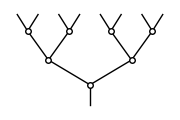

In [901]:
from matplotlib.patches import FancyBboxPatch as Box
def drawdetector(ax, x, y, v):
    ax.add_patch(Box((x,y - .015), 10, .03, "round", transform = ax.transData, facecolor = "white") )
    
    
T = 4
fig, axes = plt.subplots(1,1, figsize = (1.6, 1.))
ax = axes
xs = np.array([0.])
dx = 2 ** T
dts = np.array([.6, .7 ,.4])
plt.plot([ 0., 0.], [ -.5, 0],  c = "k", lw=1)
#plt.plot([ -4, -2], [ -.1, 0],  c = "k")
#plt.plot([
t = 0
for k, dt in enumerate(dts):
    
    #dt = 1 if t < T - 1 else .7
    for j,x in enumerate(xs):
        plt.plot([x, x - dx], [t, t + dt], c = "k", lw=1)
        plt.plot([x, x + dx], [t, t + dt], c = "k", lw=1)
        #if t < T-1:
        if t > 0:
            sign = -1 if (j % 2 == 0) else 1
            
            #plt.plot([x + sign * .5, x + sign * 2], [t, t - .1], c = "k")
            
    if k > 0:
        f = dt if k == T - 1 else dt * .5
        
        #plt.plot([xs[0] - dx, 2 ** T * 2.1], (t + dt * .6) * np.ones(2), "b--", lw=1)
        
        #plt.plot([xs[0] - dx, 2 ** T * 2.1], (t + f ) * np.ones(2), "b--", lw=1)
      #  drawdetector(ax, 2 ** T * 2.1 , t + f, 0)
    plt.plot(xs, np.ones_like(xs) * t + .0, "o", ms = 4, mec = "black", mfc = "white") #
    
    xs = np.repeat(xs, 2) 
    xs[::2] -= dx 
    xs[1::2] += dx 
    dx /= 2.
    t += dt
    
ax.axis("off")
ax.set_facecolor((1,1,1,0))
plt.subplots_adjust(left = 0.0, right = 1, top = 1, bottom = .0)
plt.savefig("../Desktop/tree.svg")

In [743]:
np.repeat([1,2,3], 2)

array([1, 1, 2, 2, 3, 3])